# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_3199142/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_3199142/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_3199142/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-14 17:33:52,816] A new study created in RDB with name: no-name-01610bd9-5774-48fd-8497-a179da245654
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<11:02,  3.02it/s]

current_loss: tensor(1.4439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4700103998184204
current_loss: tensor(1.4397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4452476501464844
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:38, 12.62it/s]

current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4465630054473877
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.445167899131775
current_loss: tensor(1.4043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4453366994857788
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4453284740447998
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:09, 10.49it/s]


current_loss_val:  1.4455070495605469
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4462671279907227
current_loss: tensor(1.4039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.44623863697052
Early Stop at iteration 8 with minimal loss tensor(1.4452, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4034, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:38,  9.16it/s]

current_loss: tensor(1.3728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4012378454208374
current_loss: tensor(1.3728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3456499576568604
current_loss: tensor(1.3348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3259, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:15, 10.21it/s]

current_loss_val:  1.3162226676940918
current_loss: tensor(1.3259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.316699743270874
current_loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:10, 10.47it/s]

current_loss_val:  1.3164646625518799


  0%|          | 7/2000 [00:00<03:08, 10.57it/s]

current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.316126823425293
current_loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.316001057624817
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:12, 10.33it/s]

current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3150627613067627
current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.313126802444458
current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:18, 10.03it/s]

current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3066871166229248
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3018122911453247
current_loss: tensor(1.2831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:15, 10.15it/s]

current_loss_val:  1.299778699874878
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2936780452728271
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2909643650054932


  1%|          | 15/2000 [00:01<03:13, 10.23it/s]

current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.290179967880249
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2897851467132568
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:11, 10.35it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2888782024383545
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2885823249816895
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:09, 10.45it/s]

current_loss_val:  1.2876801490783691
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2875474691390991
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:08, 10.51it/s]

current_loss_val:  1.2874531745910645


  1%|          | 23/2000 [00:02<03:07, 10.56it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2865526676177979
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2864688634872437
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:06, 10.59it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286258578300476
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285622000694275
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2850027084350586
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:35,  9.17it/s]

current_loss_val:  1.285151720046997
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<04:39,  7.05it/s]

current_loss_val:  1.2844977378845215
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<05:34,  5.90it/s]

current_loss_val:  1.284146785736084
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<06:20,  5.18it/s]

current_loss_val:  1.283929705619812
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<07:04,  4.63it/s]

current_loss_val:  1.2838557958602905
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<07:34,  4.33it/s]

current_loss_val:  1.2833799123764038
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<07:57,  4.12it/s]

current_loss_val:  1.283192753791809
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<08:31,  3.85it/s]

current_loss_val:  1.2822661399841309
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:05<09:28,  3.46it/s]

current_loss_val:  1.2820713520050049
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<10:03,  3.25it/s]

current_loss_val:  1.2816956043243408
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<10:13,  3.20it/s]

current_loss_val:  1.2811360359191895
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:06<10:32,  3.10it/s]

current_loss_val:  1.2807536125183105
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:06<11:49,  2.76it/s]

current_loss_val:  1.2803987264633179
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:07<14:38,  2.23it/s]

current_loss_val:  1.279700517654419
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:07<15:54,  2.05it/s]

current_loss_val:  1.2792376279830933
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:08<15:43,  2.08it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2790545225143433
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:08<14:23,  2.27it/s]

current_loss_val:  1.2800642251968384
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:08<13:29,  2.42it/s]

current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2792167663574219
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:09<12:33,  2.59it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2789545059204102
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:09<12:03,  2.70it/s]

current_loss_val:  1.2789487838745117
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 47/2000 [00:09<11:21,  2.86it/s]

tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2789192199707031
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:10<10:17,  3.16it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2786850929260254
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:10<08:18,  3.91it/s]

current_loss_val:  1.278427004814148
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2783039808273315


  3%|▎         | 51/2000 [00:10<07:46,  4.18it/s]

current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2779979705810547
current_loss: 

  3%|▎         | 52/2000 [00:10<07:54,  4.11it/s]

tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778511047363281


  3%|▎         | 53/2000 [00:11<07:21,  4.41it/s]

current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778267860412598
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:11<06:55,  4.68it/s]

current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778348922729492
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:11<06:25,  5.05it/s]

current_loss_val:  1.2771984338760376
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2757534980773926


  3%|▎         | 57/2000 [00:11<06:22,  5.08it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272821068763733
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:12<06:24,  5.05it/s]

current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726296186447144
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:12<06:21,  5.09it/s]

current_loss_val:  1.2724350690841675
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:12<06:29,  4.99it/s]

current_loss_val:  1.272068738937378
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:12<07:08,  4.53it/s]

current_loss_val:  1.2716182470321655
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:13<08:21,  3.86it/s]

current_loss_val:  1.2713860273361206
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:13<10:27,  3.09it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271247386932373
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:14<11:57,  2.70it/s]

current_loss_val:  1.2710695266723633
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:14<12:50,  2.51it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709711790084839


  3%|▎         | 66/2000 [00:14<11:08,  2.89it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709953784942627
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:14<09:41,  3.33it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710340023040771
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:15<08:34,  3.75it/s]

current_loss_val:  1.271113395690918
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:15<07:12,  4.47it/s]

current_loss_val:  1.271198034286499
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712427377700806
Early Stop at iteration 69 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:11,711] Trial 0 finished with value: -2.5419421195983887 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.093142395057173, 'penalty_decorrelation_ridge_second_difference': 22.63662278271807}. Best is trial 0 with value: -2.5419421195983887.
  0%|          | 2/2000 [00:00<03:10, 10.47it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704105377197266
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693594694137573
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:29,  9.53it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681382894515991
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678406238555908
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:19, 10.01it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674990892410278
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667282819747925
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:14, 10.26it/s]

current_loss_val:  1.2668629884719849
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266608715057373
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665475606918335


  0%|          | 10/2000 [00:00<03:11, 10.37it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266754388809204
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671970129013062


  1%|          | 13/2000 [00:01<03:30,  9.45it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672491073608398
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267783761024475


  1%|          | 13/2000 [00:01<03:43,  8.91it/s]


current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675622701644897
Early Stop at iteration 13 with minimal loss tensor(1.2665, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:13,766] Trial 1 finished with value: -2.533095121383667 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.676861429985708, 'penalty_decorrelation_ridge_second_difference': 3.7908539089517577}. Best is trial 1 with value: -2.533095121383667.
  0%|          | 2/2000 [00:00<03:14, 10.27it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701038122177124
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268213152885437
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265921950340271
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658756971359253
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659469842910767
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655333280563354
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.17it/s]

current_loss_val:  1.2659482955932617
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659708261489868
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656235694885254


  0%|          | 10/2000 [00:01<03:25,  9.71it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645937204360962
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644449472427368


  1%|          | 12/2000 [00:01<03:18, 10.00it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629646062850952
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2633287906646729


  1%|          | 14/2000 [00:01<03:36,  9.18it/s]

current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626357078552246
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622637748718262


  1%|          | 17/2000 [00:01<03:35,  9.19it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622151374816895
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614400386810303


  1%|          | 19/2000 [00:01<03:24,  9.67it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614805698394775
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261197805404663
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:35,  9.20it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622191905975342
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618945837020874
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:24,  9.65it/s]

current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615076303482056
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618467807769775
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:32,  9.29it/s]


current_loss_val:  1.261338710784912
Early Stop at iteration 23 with minimal loss tensor(1.2612, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:16,827] Trial 2 finished with value: -2.522395610809326 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.463169274406511, 'penalty_decorrelation_ridge_second_difference': 2.020232682885989}. Best is trial 2 with value: -2.522395610809326.
  0%|          | 1/2000 [00:00<04:16,  7.78it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711879014968872
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:17,  7.76it/s]

current_loss_val:  1.2726068496704102
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273597240447998
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:27,  7.47it/s]

current_loss_val:  1.2741374969482422
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750096321105957
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2762081623077393
Early Stop at iteration 5 with minimal loss tensor(1.2712, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:18,276] Trial 3 finished with value: -2.5423758029937744 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.07239307387928, 'penalty_decorrelation_ridge_second_difference': 28.922318480104938}. Best is trial 2 with value: -2.522395610809326.
  0%|          | 1/2000 [00:00<04:17,  7.76it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271098256111145
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:18,  7.72it/s]

current_loss_val:  1.2720818519592285
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726714611053467
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:27,  7.45it/s]

current_loss_val:  1.2729623317718506
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740424871444702
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748990058898926
Early Stop at iteration 5 with minimal loss tensor(1.2711, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:19,533] Trial 4 finished with value: -2.542196273803711 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.0408004999392, 'penalty_decorrelation_ridge_second_difference': 20.385685926883507}. Best is trial 2 with value: -2.522395610809326.
  0%|          | 2/2000 [00:00<03:14, 10.28it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27113676071167
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271381139755249
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:09, 10.53it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742438316345215
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732774019241333
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:48,  8.73it/s]


current_loss_val:  1.2731391191482544
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733572721481323
Early Stop at iteration 5 with minimal loss tensor(1.2711, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:20,685] Trial 5 finished with value: -2.54227352142334 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.042176575023657, 'penalty_decorrelation_ridge_second_difference': 0.8350867661441069}. Best is trial 2 with value: -2.522395610809326.
  0%|          | 2/2000 [00:00<03:08, 10.63it/s]

current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713757753372192
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717080116271973
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:26,  9.69it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750725746154785
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747149467468262
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:58,  8.35it/s]


current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747949361801147
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2752366065979004
Early Stop at iteration 5 with minimal loss tensor(1.2714, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:21,881] Trial 6 finished with value: -2.5427515506744385 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.633009017703436, 'penalty_decorrelation_ridge_second_difference': 5.412074222489641}. Best is trial 2 with value: -2.522395610809326.
  0%|          | 1/2000 [00:00<04:43,  7.04it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707798480987549
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:35,  9.26it/s]

current_loss_val:  1.2706221342086792
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694029808044434
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686340808868408


  0%|          | 5/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684215307235718
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684104442596436
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682923078536987
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676877975463867
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:11, 10.40it/s]

current_loss_val:  1.2677828073501587
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676560878753662
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676016092300415


  1%|          | 13/2000 [00:01<03:20,  9.93it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675845623016357
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267623782157898


  1%|          | 15/2000 [00:01<03:16, 10.13it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267648458480835
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677046060562134
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:30,  9.45it/s]


current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267682433128357
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678306102752686
Early Stop at iteration 16 with minimal loss tensor(1.2676, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:24,204] Trial 7 finished with value: -2.5351686477661133 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.532899186266004, 'penalty_decorrelation_ridge_second_difference': 11.572109982451092}. Best is trial 2 with value: -2.522395610809326.
  0%|          | 1/2000 [00:00<04:19,  7.71it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709097862243652
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:34,  9.29it/s]

current_loss_val:  1.2706573009490967
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688807249069214
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676814794540405


  0%|          | 6/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676751613616943
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676684856414795
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:16, 10.12it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676500082015991
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675926685333252
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:13, 10.27it/s]

current_loss_val:  1.2674485445022583
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674189805984497
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674105167388916


  1%|          | 12/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673192024230957
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671858072280884
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669137716293335
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667617797851562
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:08, 10.52it/s]

current_loss_val:  1.2666130065917969
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657853364944458
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657642364501953


  1%|          | 20/2000 [00:01<03:07, 10.55it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657294273376465
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656246423721313
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654919624328613
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:49,  8.59it/s]

current_loss_val:  1.2654649019241333
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654424905776978
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265391230583191


  1%|▏         | 26/2000 [00:02<03:36,  9.12it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653367519378662
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651299238204956
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:27,  9.49it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264938235282898
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648080587387085
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:21,  9.78it/s]

current_loss_val:  1.2646878957748413
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646328210830688
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646180391311646


  2%|▏         | 32/2000 [00:03<03:17,  9.98it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644233703613281
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264021635055542
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:14, 10.13it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635513544082642
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26340651512146
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:09, 10.38it/s]

current_loss_val:  1.2634022235870361
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2633862495422363
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2633994817733765


  2%|▏         | 40/2000 [00:04<03:17,  9.92it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636245489120483
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635259628295898


  2%|▏         | 42/2000 [00:04<03:14, 10.09it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634211778640747
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631458044052124
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:12, 10.16it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629793882369995
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627638578414917
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:10, 10.25it/s]

current_loss_val:  1.262559175491333
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622820138931274
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621734142303467


  2%|▏         | 48/2000 [00:04<03:09, 10.32it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621828317642212
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262176752090454
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:05<03:07, 10.42it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621541023254395
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620898485183716
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:05<03:04, 10.53it/s]

current_loss_val:  1.262074589729309
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620573043823242
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:28,  9.32it/s]

current_loss_val:  1.2619178295135498
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:05<04:28,  7.23it/s]

current_loss_val:  1.2618151903152466
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:06<05:28,  5.93it/s]

current_loss_val:  1.2617319822311401
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:06<06:17,  5.15it/s]

current_loss_val:  1.2611392736434937
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:06<07:01,  4.60it/s]

current_loss_val:  1.2607487440109253
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:06<07:34,  4.27it/s]

current_loss_val:  1.260501742362976
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:07<08:04,  4.00it/s]

current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260546326637268


  3%|▎         | 61/2000 [00:07<08:38,  3.74it/s]

current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605876922607422
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:07<09:29,  3.40it/s]

current_loss_val:  1.2607145309448242
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:08<10:02,  3.22it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260858416557312
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:08<04:23,  7.36it/s]

current_loss_val:  1.2609353065490723
Early Stop at iteration 63 with minimal loss tensor(1.2605, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:33,570] Trial 8 finished with value: -2.521003246307373 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.320350690737097, 'penalty_decorrelation_ridge_second_difference': 29.747700903608813}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<08:52,  3.76it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702083587646484


  0%|          | 2/2000 [00:00<07:32,  4.42it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694997787475586
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:59,  3.03it/s]

current_loss_val:  1.2660720348358154
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<13:20,  2.49it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266558289527893
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<14:12,  2.34it/s]

current_loss_val:  1.265773057937622
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<14:41,  2.26it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657525539398193


  0%|          | 7/2000 [00:02<13:32,  2.45it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661019563674927


  0%|          | 8/2000 [00:02<11:17,  2.94it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661281824111938


  0%|          | 9/2000 [00:03<09:53,  3.36it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663220167160034


  0%|          | 10/2000 [00:03<09:02,  3.67it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266259789466858


  0%|          | 10/2000 [00:03<11:41,  2.84it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659289836883545
Early Stop at iteration 10 with minimal loss tensor(1.2658, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:37,751] Trial 9 finished with value: -2.5315048694610596 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.769182541080629, 'penalty_decorrelation_ridge_second_difference': 12.32300140967613}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<08:09,  4.08it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708152532577515
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:29,  3.92it/s]

current_loss_val:  1.2695082426071167
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:02,  4.14it/s]

current_loss_val:  1.267228126525879
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267133116722107


  0%|          | 5/2000 [00:01<07:19,  4.54it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267106533050537


  0%|          | 6/2000 [00:01<07:05,  4.69it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670475244522095
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:57,  4.77it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266961932182312
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<06:32,  5.07it/s]

current_loss_val:  1.2668302059173584
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662965059280396


  0%|          | 10/2000 [00:02<06:27,  5.13it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662385702133179
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<06:48,  4.87it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266202449798584
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<06:42,  4.94it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660505771636963
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:39,  7.10it/s]

current_loss_val:  1.2658628225326538
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656244039535522
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26537024974823


  1%|          | 17/2000 [00:03<04:02,  8.16it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646523714065552
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642779350280762
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<05:38,  5.85it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641583681106567
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<08:01,  4.12it/s]

current_loss_val:  1.2633610963821411
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<09:51,  3.35it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262704610824585


  1%|          | 21/2000 [00:04<08:40,  3.80it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626057863235474
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625247240066528
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:04<06:17,  5.24it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623481750488281
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:05<07:48,  4.22it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618061304092407
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:05<09:47,  3.36it/s]

current_loss_val:  1.261838674545288
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<10:54,  3.02it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618744373321533
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<07:33,  4.35it/s]

current_loss_val:  1.261918067932129
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619160413742065
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<07:23,  4.44it/s]


current_loss_val:  1.2619556188583374
Early Stop at iteration 28 with minimal loss tensor(1.2618, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:44,666] Trial 10 finished with value: -2.5236117839813232 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.4095903451326786, 'penalty_decorrelation_ridge_second_difference': 22.856053433843904}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 2/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707138061523438
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705596685409546


  0%|          | 4/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701936960220337
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693272829055786
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:13, 10.30it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694809436798096
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691618204116821
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:12, 10.35it/s]

current_loss_val:  1.268913984298706
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269098162651062
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270102620124817


  0%|          | 10/2000 [00:00<03:11, 10.37it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694158554077148
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693145275115967
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:30,  9.47it/s]


current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693511247634888
Early Stop at iteration 11 with minimal loss tensor(1.2689, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:46,490] Trial 11 finished with value: -2.537827968597412 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.733744456786718, 'penalty_decorrelation_ridge_second_difference': 5.425382721944592}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710356712341309
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:30,  9.47it/s]

current_loss_val:  1.2713384628295898
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722636461257935
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722764015197754


  0%|          | 5/2000 [00:00<04:16,  7.77it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272261381149292
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721883058547974
Early Stop at iteration 5 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:47,767] Trial 12 finished with value: -2.5420713424682617 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.801913599259294, 'penalty_decorrelation_ridge_second_difference': 24.789052619893177}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709470987319946
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:34,  9.32it/s]

current_loss_val:  1.2709245681762695
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270739197731018
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706665992736816


  0%|          | 6/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706952095031738
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706882953643799
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706140279769897
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701127529144287
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:15, 10.18it/s]

current_loss_val:  1.2700741291046143
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270047664642334
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700092792510986


  1%|          | 12/2000 [00:01<03:14, 10.23it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700936794281006
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701311111450195
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:13, 10.26it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270194411277771
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702898979187012
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:29,  9.46it/s]


current_loss_val:  1.2705602645874023
Early Stop at iteration 15 with minimal loss tensor(1.2700, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:50,042] Trial 13 finished with value: -2.5400185585021973 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.497847606971147, 'penalty_decorrelation_ridge_second_difference': 12.887477582896212}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702447175979614
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269932746887207
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:13, 10.34it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684756517410278
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669578790664673
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:30,  9.48it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266479730606079
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662320137023926
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:21,  9.87it/s]

current_loss_val:  1.2657376527786255
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652589082717896
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640587091445923


  0%|          | 10/2000 [00:01<03:32,  9.37it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634260654449463
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636147737503052


  1%|          | 12/2000 [00:01<03:22,  9.80it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637377977371216
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640082836151123
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:39,  9.03it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264228105545044
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644140720367432
Early Stop at iteration 14 with minimal loss tensor(1.2634, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:52,206] Trial 14 finished with value: -2.5268521308898926 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5872734645988587, 'penalty_decorrelation_ridge_second_difference': 14.757124445514894}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<04:32,  7.34it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708994150161743
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:58,  8.39it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705224752426147
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268495798110962
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:31,  9.44it/s]

current_loss_val:  1.2673975229263306
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674446105957031
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674624919891357


  0%|          | 7/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674790620803833
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675055265426636
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:55,  8.46it/s]


current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674694061279297
Early Stop at iteration 8 with minimal loss tensor(1.2674, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:34:53,779] Trial 15 finished with value: -2.5347955226898193 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.661418906082794, 'penalty_decorrelation_ridge_second_difference': 29.495550435095424}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 2/2000 [00:00<03:42,  8.99it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269920825958252
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688626050949097


  0%|          | 4/2000 [00:00<03:23,  9.83it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644822597503662
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264859676361084
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:22,  9.85it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264979362487793
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649179697036743
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:59,  8.33it/s]

current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656272649765015
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26492440700531
Early Stop at iteration 7 with minimal loss tensor(1.2645, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:55,264] Trial 16 finished with value: -2.5289642810821533 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.330783963390446, 'penalty_decorrelation_ridge_second_difference': 0.8321129837654608}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<12:49,  2.60it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709616422653198
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:27,  5.16it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709044218063354
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706407308578491
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:04,  6.55it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2703665494918823
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700647115707397


  0%|          | 7/2000 [00:01<04:09,  7.99it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694205045700073
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268873691558838


  0%|          | 9/2000 [00:01<03:45,  8.81it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685401439666748
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676340341567993


  0%|          | 10/2000 [00:01<03:42,  8.96it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663953304290771
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656702995300293


  1%|          | 13/2000 [00:01<03:31,  9.41it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649705410003662
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630292177200317


  1%|          | 15/2000 [00:01<03:24,  9.72it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262805461883545
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627695798873901
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<03:24,  9.68it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625689506530762
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262702465057373
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:18,  9.98it/s]

current_loss_val:  1.262671947479248
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262657642364502
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26266610622406


  1%|          | 20/2000 [00:02<04:14,  7.79it/s]

current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627427577972412
Early Stop at iteration 20 with minimal loss tensor(1.2626, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:34:58,571] Trial 17 finished with value: -2.5251376628875732 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.91605629382845, 'penalty_decorrelation_ridge_second_difference': 26.248170612631657}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<04:54,  6.80it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702869176864624
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:47,  6.95it/s]

current_loss_val:  1.2686198949813843
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267503261566162
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:01,  8.26it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674386501312256
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669979333877563
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:03,  8.18it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664402723312378
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664124965667725


  0%|          | 8/2000 [00:00<03:50,  8.64it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661802768707275
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652614116668701
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:51,  8.60it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651398181915283
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647111415863037
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:47,  8.73it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636147737503052
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629153728485107
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:40,  9.00it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628899812698364
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626169919967651
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:28,  9.51it/s]

current_loss_val:  1.2617398500442505
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626370191574097
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:21,  9.81it/s]

current_loss_val:  1.2624107599258423
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262431263923645
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263919711112976


  1%|          | 20/2000 [00:02<03:52,  8.53it/s]


current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631043195724487
Early Stop at iteration 20 with minimal loss tensor(1.2617, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:35:01,628] Trial 18 finished with value: -2.523479461669922 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.250191654152879, 'penalty_decorrelation_ridge_second_difference': 1.242510842956145}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<04:19,  7.71it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708617448806763
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:58,  8.36it/s]

current_loss_val:  1.2703909873962402
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268487811088562
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:32,  9.41it/s]

current_loss_val:  1.2678543329238892
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679922580718994
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680882215499878


  0%|          | 7/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682485580444336
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<04:06,  8.08it/s]

current_loss_val:  1.2682955265045166
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683038711547852
Early Stop at iteration 8 with minimal loss tensor(1.2679, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:35:03,332] Trial 19 finished with value: -2.535708427429199 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.561382115794438, 'penalty_decorrelation_ridge_second_difference': 20.845064767273325}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 1/2000 [00:00<04:22,  7.62it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270981788635254
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:59,  8.35it/s]

current_loss_val:  1.2710098028182983
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271054983139038
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:24,  7.53it/s]

current_loss_val:  1.2709475755691528
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708823680877686


  0%|          | 7/2000 [00:00<04:40,  7.10it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707464694976807
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704178094863892


  0%|          | 9/2000 [00:01<04:00,  8.29it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701963186264038
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699660062789917
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:44,  8.87it/s]

current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686878442764282
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683182954788208
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:30,  9.44it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679866552352905
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667361497879028
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:39,  9.06it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655928134918213
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650669813156128
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:41,  8.94it/s]

current_loss_val:  1.26375150680542
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635332345962524
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:34,  9.24it/s]

current_loss_val:  1.2634438276290894
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627527713775635
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624790668487549


  1%|          | 21/2000 [00:02<03:24,  9.69it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262505292892456
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625468969345093
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:18,  9.95it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625977993011475
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628576755523682
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:52,  8.51it/s]


current_loss_val:  1.2629626989364624
Early Stop at iteration 24 with minimal loss tensor(1.2625, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:35:06,785] Trial 20 finished with value: -2.5249578952789307 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.132592521351036, 'penalty_decorrelation_ridge_second_difference': 29.463670219416347}. Best is trial 8 with value: -2.521003246307373.
  0%|          | 2/2000 [00:00<03:10, 10.49it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702109813690186
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2682198286056519
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26705002784729
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:55,  8.49it/s]

current_loss_val:  1.2664811611175537
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653303146362305
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:05,  8.11it/s]

current_loss_val:  1.2655819654464722
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654681205749512
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:56,  8.41it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648377418518066
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265142798423767
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:49,  8.68it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649168968200684
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643965482711792
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:48,  8.72it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637817859649658
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637600898742676
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:31,  9.37it/s]

current_loss_val:  1.2636035680770874
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627490758895874
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629224061965942


  1%|          | 17/2000 [00:01<03:23,  9.75it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628110647201538
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:24,  9.67it/s]

current_loss_val:  1.2617923021316528
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261832594871521
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618714570999146


  1%|          | 21/2000 [00:02<03:28,  9.48it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614470720291138
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:28,  9.48it/s]

current_loss_val:  1.2620470523834229
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261857271194458
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261899471282959


  1%|▏         | 25/2000 [00:02<03:39,  9.00it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261252760887146
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:42,  8.87it/s]

current_loss_val:  1.2610312700271606
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605088949203491
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:00,  8.20it/s]

current_loss_val:  1.260909914970398
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260716438293457
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:51,  8.50it/s]

current_loss_val:  1.260483741760254
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608983516693115
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:35,  9.11it/s]

current_loss_val:  1.2607349157333374
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605178356170654
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:38,  7.05it/s]

current_loss_val:  1.2608511447906494
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603236436843872
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605701684951782


  2%|▏         | 37/2000 [00:04<04:02,  8.11it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606585025787354
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607345581054688
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:58,  8.24it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605085372924805
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:53,  8.40it/s]


current_loss_val:  1.2605732679367065
Early Stop at iteration 39 with minimal loss tensor(1.2603, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:35:12,095] Trial 21 finished with value: -2.5206472873687744 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.064328050609426, 'penalty_decorrelation_ridge_second_difference': 3.2944343237904263}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 2/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701448202133179
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681018114089966
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:38,  9.13it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266440987586975
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660890817642212
current_loss: 

  0%|          | 5/2000 [00:00<03:32,  9.41it/s]

tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654857635498047
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647391557693481
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265037178993225
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646921873092651
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:16, 10.14it/s]

current_loss_val:  1.2646323442459106
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648388147354126
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658382654190063


  1%|          | 12/2000 [00:01<03:14, 10.20it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653248310089111
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265223503112793
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:35,  9.23it/s]


current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651939392089844
Early Stop at iteration 13 with minimal loss tensor(1.2646, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:35:14,163] Trial 22 finished with value: -2.5292646884918213 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.5848019556604727, 'penalty_decorrelation_ridge_second_difference': 6.665269336954387}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 2/2000 [00:00<03:10, 10.49it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706382274627686
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700207233428955
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270073413848877
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269223928451538
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:13, 10.30it/s]

current_loss_val:  1.2687331438064575
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683242559432983
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671126127243042


  0%|          | 8/2000 [00:00<03:13, 10.28it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672181129455566
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671931982040405
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:13, 10.27it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658545970916748
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665239572525024
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:24,  9.71it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662853002548218
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663662433624268
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:41,  8.98it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654087543487549
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658451795578003
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:42,  8.93it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267699122428894
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672239542007446
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:38,  9.09it/s]


current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672885656356812
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673283815383911
Early Stop at iteration 18 with minimal loss tensor(1.2654, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:35:16,835] Trial 23 finished with value: -2.5308170318603516 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.963937066676767, 'penalty_decorrelation_ridge_second_difference': 0.8886926327291016}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 2/2000 [00:00<03:08, 10.62it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700064182281494
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267072319984436
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:29,  9.51it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654236555099487
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26527738571167
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:41,  8.98it/s]

current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637571096420288
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264183759689331
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:57,  8.40it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264026165008545
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637933492660522
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:05,  8.11it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642652988433838
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638667821884155
Early Stop at iteration 9 with minimal loss tensor(1.2638, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:35:18,601] Trial 24 finished with value: -2.5275142192840576 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1493642499786572, 'penalty_decorrelation_ridge_second_difference': 5.980526117197206}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 2/2000 [00:00<03:44,  8.89it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700914144515991
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691093683242798


  0%|          | 4/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654732465744019
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662594318389893
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:29,  9.52it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664306163787842
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662628889083862
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:54,  8.51it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666590213775635
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665730714797974
Early Stop at iteration 7 with minimal loss tensor(1.2655, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:35:20,050] Trial 25 finished with value: -2.5309462547302246 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.879128030832515, 'penalty_decorrelation_ridge_second_difference': 0.19038973991584163}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 1/2000 [00:00<04:30,  7.40it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708619832992554
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 3/2000 [00:00<03:59,  8.34it/s]

tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2703064680099487
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674219608306885
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:52,  8.60it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267027735710144
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266885757446289
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:31,  9.44it/s]

current_loss_val:  1.266276478767395
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660123109817505
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660247087478638


  0%|          | 9/2000 [00:00<03:24,  9.71it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660179138183594
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660080194473267
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:19,  9.95it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266061782836914
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660706043243408
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:23,  9.78it/s]

current_loss_val:  1.2660877704620361
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661292552947998
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:47,  8.72it/s]


current_loss_val:  1.2662698030471802
Early Stop at iteration 14 with minimal loss tensor(1.2660, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:35:22,307] Trial 26 finished with value: -2.532015800476074 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.442104848665382, 'penalty_decorrelation_ridge_second_difference': 27.544600703908877}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 2/2000 [00:00<03:10, 10.51it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702641487121582
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269241213798523
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:11, 10.40it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662642002105713
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672852277755737
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:14, 10.28it/s]

current_loss_val:  1.2667182683944702
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665185928344727
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665598392486572


  0%|          | 7/2000 [00:00<03:41,  9.00it/s]


current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670115232467651
Early Stop at iteration 7 with minimal loss tensor(1.2663, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-14 17:35:23,754] Trial 27 finished with value: -2.5325284004211426 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.1480194522152045, 'penalty_decorrelation_ridge_second_difference': 8.670891853286806}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 1/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704678773880005
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700914144515991
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:16, 10.18it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686089277267456
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268527865409851
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.33it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679086923599243
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673648595809937
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:20,  9.91it/s]

current_loss_val:  1.267134189605713
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662383317947388
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661057710647583


  1%|          | 11/2000 [00:01<03:28,  9.55it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646253108978271
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648869752883911


  1%|          | 12/2000 [00:01<03:39,  9.07it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643028497695923
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:42,  8.93it/s]

current_loss_val:  1.2637122869491577
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625954151153564
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:32,  9.34it/s]

current_loss_val:  1.2625852823257446
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622929811477661
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628650665283203


  1%|          | 19/2000 [00:01<03:26,  9.58it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617429494857788
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618199586868286


  1%|          | 20/2000 [00:02<03:24,  9.66it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623602151870728
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262231469154358
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:33,  9.28it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614599466323853
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619434595108032
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:36,  9.13it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262189269065857
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618119716644287
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:36,  9.10it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622233629226685
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26237952709198
Early Stop at iteration 26 with minimal loss tensor(1.2615, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:35:27,334] Trial 28 finished with value: -2.5229194164276123 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.21404693429325, 'penalty_decorrelation_ridge_second_difference': 8.07180624003421}. Best is trial 21 with value: -2.5206472873687744.
  0%|          | 1/2000 [00:00<04:19,  7.69it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270922303199768
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:39,  9.10it/s]

current_loss_val:  1.2706701755523682
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698298692703247
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694716453552246


  0%|          | 6/2000 [00:00<03:25,  9.70it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693392038345337
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2689403295516968
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:26,  9.64it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683442831039429
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2675998210906982
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670506238937378
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666665315628052
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:17, 10.06it/s]

current_loss_val:  1.2654222249984741
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635754346847534
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636216878890991


  1%|          | 14/2000 [00:01<03:14, 10.19it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637207508087158
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263970136642456
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:36,  9.18it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264864206314087
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650084495544434
Early Stop at iteration 16 with minimal loss tensor(1.2636, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-14 17:35:29,911] Trial 29 finished with value: -2.527150869369507 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.01004039502358, 'penalty_decorrelation_ridge_second_difference': 20.71228775521654}. Best is trial 21 with value: -2.5206472873687744.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<00:58, 17.15it/s]

current_loss: tensor(1.4353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4043, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<00:48, 20.51it/s]

current_loss: tensor(1.4043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:45, 21.68it/s]

current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4034, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<00:45, 21.53it/s]

current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:45, 21.78it/s]

current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:00<00:44, 21.88it/s]

current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<00:42, 22.91it/s]

current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:01<00:39, 24.40it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:01<00:39, 24.59it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:01<00:39, 24.55it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:01<00:37, 25.55it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:01<00:37, 25.45it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:01<00:36, 26.16it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:01<00:38, 24.57it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 47/1000 [00:02<01:03, 14.97it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:02<00:49, 19.21it/s]

current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 48 with minimal loss tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4012, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:41,  9.84it/s]

current_loss: tensor(1.3640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4017622470855713
current_loss: tensor(1.3640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3315833806991577
current_loss: tensor(1.3081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3760, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:51,  8.93it/s]

current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3103759288787842
current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3027968406677246
current_loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:41,  9.76it/s]

current_loss_val:  1.2982587814331055
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2965750694274902
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:38, 10.04it/s]

current_loss_val:  1.2875179052352905


  1%|          | 9/1000 [00:00<01:37, 10.21it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2920525074005127
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2875877618789673
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:01<01:35, 10.31it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2866517305374146
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285266637802124
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:40,  9.78it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2860448360443115
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2851834297180176
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:38,  9.97it/s]

current_loss_val:  1.2838927507400513
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2813068628311157
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:42,  9.60it/s]

current_loss_val:  1.28183114528656
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2798751592636108
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.279400110244751


  2%|▏         | 19/1000 [00:01<01:39,  9.85it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2806644439697266
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:02<01:44,  9.39it/s]

current_loss_val:  1.2762562036514282


  2%|▏         | 21/1000 [00:02<01:44,  9.41it/s]

current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2763848304748535
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276023507118225
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:02<01:40,  9.76it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748069763183594
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743381261825562
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:02<01:37,  9.98it/s]

current_loss_val:  1.2730990648269653
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730810642242432
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:36, 10.12it/s]

current_loss_val:  1.273050308227539


  3%|▎         | 29/1000 [00:02<01:34, 10.22it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719844579696655
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272172451019287
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:03<01:34, 10.27it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720569372177124
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269864559173584
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:03<01:33, 10.32it/s]

current_loss_val:  1.2702703475952148
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269375205039978
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267441987991333


  4%|▎         | 35/1000 [00:03<01:33, 10.33it/s]

current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647522687911987
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653950452804565
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:03<01:33, 10.35it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653846740722656
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641452550888062
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:03<01:32, 10.37it/s]

current_loss_val:  1.2649821043014526
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647122144699097
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:04<01:31, 10.43it/s]

current_loss_val:  1.2629871368408203


  4%|▍         | 43/1000 [00:04<01:32, 10.34it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636983394622803
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636631727218628
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:04<01:32, 10.30it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627944946289062
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26356041431427
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:04<01:32, 10.32it/s]

current_loss_val:  1.263646125793457
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26369047164917
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630354166030884


  5%|▍         | 48/1000 [00:04<01:36,  9.88it/s]


current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632954120635986
Early Stop at iteration 48 with minimal loss tensor(1.2628, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =1.0,
                tau_vi_sigma_init = 0.15,
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 0/800 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  0%|          | 1/800 [00:16<3:43:53, 16.81s/it]


Iteration [1/800] train=12.4589    val_ELPD=-0.0415  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.18068  τ₁≈5.3482  τ₂≈10.909  |  (EB targets) τ₄*≈0.53537  τ₁*≈118.57  τ₂*≈163.79
E_qf_total≈37.3513  E_qf1≈0.3102  E_qf2≈0.3019
[monitor] τ₄·E_qf≈6.75  target≈20.00 | τ₁·E_qf1≈1.66  target≈36.77 | τ₂·E_qf2≈3.29  target≈49.44
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 2/800 [00:21<2:07:19,  9.57s/it]


Iteration [2/800] train=12.2877    val_ELPD=-0.0405  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.29
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.15977  τ₁≈5.2241  τ₂≈10.752  |  (EB targets) τ₄*≈0.53821  τ₁*≈117.72  τ₂*≈163.68
E_qf_total≈37.1540  E_qf1≈0.3153  E_qf2≈0.3022
[monitor] τ₄·E_qf≈5.94  target≈20.00 | τ₁·E_qf1≈1.65  target≈37.11 | τ₂·E_qf2≈3.25  target≈49.46
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 3/800 [00:25<1:36:25,  7.26s/it]


Iteration [3/800] train=12.1404    val_ELPD=-0.0397  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.28
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.1447  τ₁≈5.1134  τ₂≈10.597  |  (EB targets) τ₄*≈0.54082  τ₁*≈116.43  τ₂*≈162.71
E_qf_total≈36.9743  E_qf1≈0.3232  E_qf2≈0.3052
[monitor] τ₄·E_qf≈5.35  target≈20.00 | τ₁·E_qf1≈1.65  target≈37.63 | τ₂·E_qf2≈3.23  target≈49.66
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 4/800 [00:30<1:21:51,  6.17s/it]


Iteration [4/800] train=12.0330    val_ELPD=-0.0392  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.1296  τ₁≈4.9629  τ₂≈10.491  |  (EB targets) τ₄*≈0.54331  τ₁*≈115.18  τ₂*≈162.06
E_qf_total≈36.8049  E_qf1≈0.3310  E_qf2≈0.3072
[monitor] τ₄·E_qf≈4.77  target≈20.00 | τ₁·E_qf1≈1.64  target≈38.13 | τ₂·E_qf2≈3.22  target≈49.79
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 5/800 [00:34<1:13:43,  5.56s/it]


Iteration [5/800] train=11.8996    val_ELPD=-0.0389  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.26
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.11776  τ₁≈4.8352  τ₂≈10.315  |  (EB targets) τ₄*≈0.54576  τ₁*≈114.99  τ₂*≈164.27
E_qf_total≈36.6396  E_qf1≈0.3323  E_qf2≈0.3004
[monitor] τ₄·E_qf≈4.31  target≈20.00 | τ₁·E_qf1≈1.61  target≈38.21 | τ₂·E_qf2≈3.10  target≈49.35
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 6/800 [00:39<1:08:47,  5.20s/it]


Iteration [6/800] train=11.7604    val_ELPD=-0.0385  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.25
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10859  τ₁≈4.7073  τ₂≈10.229  |  (EB targets) τ₄*≈0.54777  τ₁*≈113.69  τ₂*≈163.58
E_qf_total≈36.5054  E_qf1≈0.3406  E_qf2≈0.3025
[monitor] τ₄·E_qf≈3.96  target≈20.00 | τ₁·E_qf1≈1.60  target≈38.73 | τ₂·E_qf2≈3.09  target≈49.48
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 7/800 [00:43<1:05:38,  4.97s/it]


Iteration [7/800] train=11.6450    val_ELPD=-0.0384  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.24
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.095079  τ₁≈4.5901  τ₂≈10.078  |  (EB targets) τ₄*≈0.54978  τ₁*≈112.85  τ₂*≈163.14
E_qf_total≈36.3721  E_qf1≈0.3461  E_qf2≈0.3039
[monitor] τ₄·E_qf≈3.46  target≈20.00 | τ₁·E_qf1≈1.59  target≈39.06 | τ₂·E_qf2≈3.06  target≈49.57
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 8/800 [00:48<1:03:31,  4.81s/it]


Iteration [8/800] train=11.5730    val_ELPD=-0.0381  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.094215  τ₁≈4.4944  τ₂≈9.9593  |  (EB targets) τ₄*≈0.55149  τ₁*≈112.74  τ₂*≈163.46
E_qf_total≈36.2590  E_qf1≈0.3469  E_qf2≈0.3029
[monitor] τ₄·E_qf≈3.42  target≈20.00 | τ₁·E_qf1≈1.56  target≈39.11 | τ₂·E_qf2≈3.02  target≈49.51
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 9/800 [00:52<1:02:05,  4.71s/it]

NOT IMPROVED! Nr. 1


  1%|▏         | 10/800 [00:57<1:01:05,  4.64s/it]


Iteration [10/800] train=11.3215    val_ELPD=-0.0380  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.21
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.080916  τ₁≈4.1451  τ₂≈9.682  |  (EB targets) τ₄*≈0.55456  τ₁*≈110.86  τ₂*≈162.45
E_qf_total≈36.0583  E_qf1≈0.3595  E_qf2≈0.3060
[monitor] τ₄·E_qf≈2.92  target≈20.00 | τ₁·E_qf1≈1.49  target≈39.86 | τ₂·E_qf2≈2.96  target≈49.71
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 11/800 [01:01<1:00:22,  4.59s/it]


Iteration [11/800] train=11.2265    val_ELPD=-0.0378  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.20
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.077352  τ₁≈4.0579  τ₂≈9.6121  |  (EB targets) τ₄*≈0.55573  τ₁*≈110.75  τ₂*≈162.4
E_qf_total≈35.9820  E_qf1≈0.3603  E_qf2≈0.3061
[monitor] τ₄·E_qf≈2.78  target≈20.00 | τ₁·E_qf1≈1.46  target≈39.90 | τ₂·E_qf2≈2.94  target≈49.72
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 12/800 [01:06<59:50,  4.56s/it]  

NOT IMPROVED! Nr. 1


  2%|▏         | 13/800 [01:10<59:26,  4.53s/it]

NOT IMPROVED! Nr. 2


  2%|▏         | 14/800 [01:15<59:09,  4.52s/it]


Iteration [14/800] train=10.9034    val_ELPD=-0.0375  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.17
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.063978  τ₁≈3.7004  τ₂≈9.1355  |  (EB targets) τ₄*≈0.55884  τ₁*≈109.42  τ₂*≈161.44
E_qf_total≈35.7819  E_qf1≈0.3695  E_qf2≈0.3092
[monitor] τ₄·E_qf≈2.29  target≈20.00 | τ₁·E_qf1≈1.37  target≈40.43 | τ₂·E_qf2≈2.82  target≈49.91
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 15/800 [01:19<58:56,  4.51s/it]

NOT IMPROVED! Nr. 1

Iteration [15/800] train=10.8280    val_ELPD=-0.0375  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.16
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.065099  τ₁≈3.5173  τ₂≈8.9572  |  (EB targets) τ₄*≈0.55983  τ₁*≈109.64  τ₂*≈163.17
E_qf_total≈35.7190  E_qf1≈0.3680  E_qf2≈0.3038
[monitor] τ₄·E_qf≈2.33  target≈20.00 | τ₁·E_qf1≈1.29  target≈40.34 | τ₂·E_qf2≈2.72  target≈49.57
 ELPD trend → NOT improved! (1/10)


  2%|▏         | 16/800 [01:24<58:46,  4.50s/it]


Iteration [16/800] train=10.7665    val_ELPD=-0.0373  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.15
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.063284  τ₁≈3.3486  τ₂≈8.9255  |  (EB targets) τ₄*≈0.56025  τ₁*≈110.01  τ₂*≈163.96
E_qf_total≈35.6920  E_qf1≈0.3654  E_qf2≈0.3013
[monitor] τ₄·E_qf≈2.26  target≈20.00 | τ₁·E_qf1≈1.22  target≈40.20 | τ₂·E_qf2≈2.69  target≈49.41
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 17/800 [01:28<58:36,  4.49s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 18/800 [01:33<58:28,  4.49s/it]


Iteration [18/800] train=10.4974    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.13
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.057899  τ₁≈3.4971  τ₂≈8.603  |  (EB targets) τ₄*≈0.56135  τ₁*≈108.42  τ₂*≈161.24
E_qf_total≈35.6218  E_qf1≈0.3766  E_qf2≈0.3098
[monitor] τ₄·E_qf≈2.06  target≈20.00 | τ₁·E_qf1≈1.32  target≈40.83 | τ₂·E_qf2≈2.67  target≈49.95
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 19/800 [01:37<58:22,  4.48s/it]

NOT IMPROVED! Nr. 1


  2%|▎         | 20/800 [01:42<58:15,  4.48s/it]

NOT IMPROVED! Nr. 2

Iteration [20/800] train=10.3379    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.11
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.062518  τ₁≈3.3185  τ₂≈8.6786  |  (EB targets) τ₄*≈0.56181  τ₁*≈108.47  τ₂*≈161.93
E_qf_total≈35.5925  E_qf1≈0.3763  E_qf2≈0.3076
[monitor] τ₄·E_qf≈2.23  target≈20.00 | τ₁·E_qf1≈1.25  target≈40.81 | τ₂·E_qf2≈2.67  target≈49.81
 ELPD trend → NOT improved! (2/10)


  3%|▎         | 21/800 [01:46<58:10,  4.48s/it]

NOT IMPROVED! Nr. 3


  3%|▎         | 22/800 [01:50<58:05,  4.48s/it]


Iteration [22/800] train=10.2056    val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.045745  τ₁≈2.8708  τ₂≈8.5978  |  (EB targets) τ₄*≈0.56191  τ₁*≈108.22  τ₂*≈161.16
E_qf_total≈35.5865  E_qf1≈0.3781  E_qf2≈0.3101
[monitor] τ₄·E_qf≈1.63  target≈20.00 | τ₁·E_qf1≈1.09  target≈40.91 | τ₂·E_qf2≈2.67  target≈49.97
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 23/800 [01:55<58:00,  4.48s/it]

NOT IMPROVED! Nr. 1


  3%|▎         | 24/800 [01:59<57:54,  4.48s/it]

NOT IMPROVED! Nr. 2


  3%|▎         | 25/800 [02:04<57:50,  4.48s/it]

NOT IMPROVED! Nr. 3

Iteration [25/800] train=10.1874    val_ELPD=-0.0373  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.043289  τ₁≈2.8956  τ₂≈7.8489  |  (EB targets) τ₄*≈0.56104  τ₁*≈108.42  τ₂*≈162.42
E_qf_total≈35.6416  E_qf1≈0.3766  E_qf2≈0.3061
[monitor] τ₄·E_qf≈1.54  target≈20.00 | τ₁·E_qf1≈1.09  target≈40.83 | τ₂·E_qf2≈2.40  target≈49.72
 ELPD trend → NOT improved! (3/10)


  3%|▎         | 26/800 [02:08<57:45,  4.48s/it]

NOT IMPROVED! Nr. 4


  3%|▎         | 27/800 [02:13<57:40,  4.48s/it]


Iteration [27/800] train=10.0763    val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.038521  τ₁≈2.8707  τ₂≈7.7173  |  (EB targets) τ₄*≈0.5599  τ₁*≈106.59  τ₂*≈158.91
E_qf_total≈35.7142  E_qf1≈0.3899  E_qf2≈0.3173
[monitor] τ₄·E_qf≈1.38  target≈20.00 | τ₁·E_qf1≈1.12  target≈41.56 | τ₂·E_qf2≈2.45  target≈50.42
 ELPD trend → IMPROVED! Congrats (0/10)


  4%|▎         | 28/800 [02:17<57:37,  4.48s/it]

NOT IMPROVED! Nr. 1


  4%|▎         | 29/800 [02:22<57:32,  4.48s/it]

NOT IMPROVED! Nr. 2


  4%|▍         | 30/800 [02:26<57:27,  4.48s/it]

NOT IMPROVED! Nr. 3

Iteration [30/800] train=10.0769    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.031874  τ₁≈3.2616  τ₂≈7.7987  |  (EB targets) τ₄*≈0.55709  τ₁*≈108.41  τ₂*≈164.01
E_qf_total≈35.8943  E_qf1≈0.3767  E_qf2≈0.3012
[monitor] τ₄·E_qf≈1.14  target≈20.00 | τ₁·E_qf1≈1.23  target≈40.84 | τ₂·E_qf2≈2.35  target≈49.40
 ELPD trend → NOT improved! (3/10)


  4%|▍         | 31/800 [02:31<57:35,  4.49s/it]

NOT IMPROVED! Nr. 4


  4%|▍         | 32/800 [02:35<58:05,  4.54s/it]

NOT IMPROVED! Nr. 5


  4%|▍         | 33/800 [02:40<58:08,  4.55s/it]

NOT IMPROVED! Nr. 6


  4%|▍         | 34/800 [02:45<57:51,  4.53s/it]

NOT IMPROVED! Nr. 7


  4%|▍         | 35/800 [02:49<57:40,  4.52s/it]

NOT IMPROVED! Nr. 8

Iteration [35/800] train=9.1119    val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0600 σmin=0.0600 σmax=0.0600  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.045961  τ₁≈3.4616  τ₂≈7.4215  |  (EB targets) τ₄*≈0.55209  τ₁*≈92.004  τ₂*≈129.37
E_qf_total≈36.2199  E_qf1≈0.5152  E_qf2≈0.4354
[monitor] τ₄·E_qf≈1.66  target≈20.00 | τ₁·E_qf1≈1.78  target≈47.40 | τ₂·E_qf2≈3.23  target≈56.33
 ELPD trend → NOT improved! (8/10)


  4%|▍         | 36/800 [02:54<57:29,  4.52s/it]

NOT IMPROVED! Nr. 9


  4%|▍         | 36/800 [02:58<1:03:08,  4.96s/it]

NOT IMPROVED! Nr. 10
Early stop @ epoch 37: no val improvement for 10 epochs.


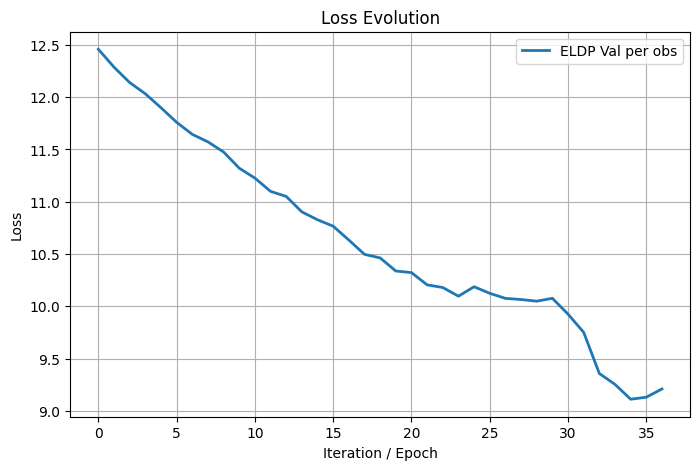

In [11]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0306
KLD GTM      Train Data:  0.0115
KLD Gaussian Train Data:  0.103
KLD Copula   Train Data:  -0.0015

KLD BGTM      Test  Data:  0.0336
KLD GTM      Test  Data:  0.0129
KLD Gaussian Test  Data:  0.1058
KLD Copula   Test  Data:  0.0028


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

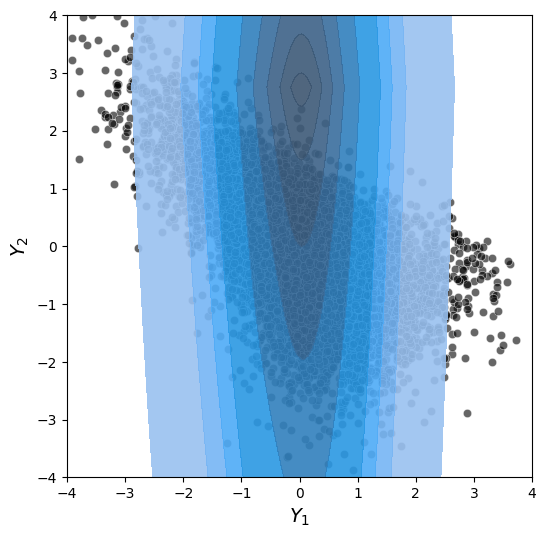

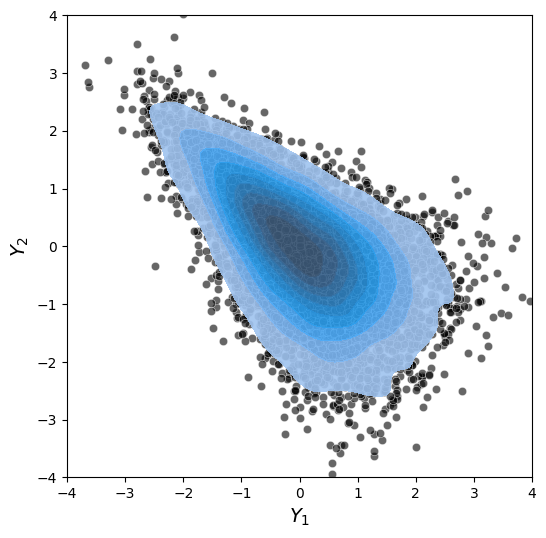

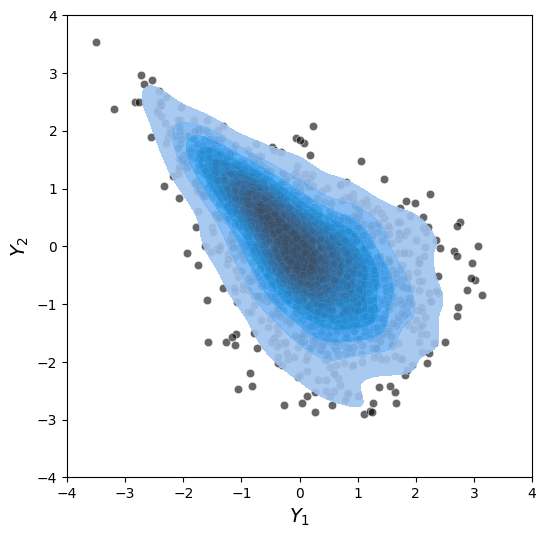

In [16]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [17]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [18]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


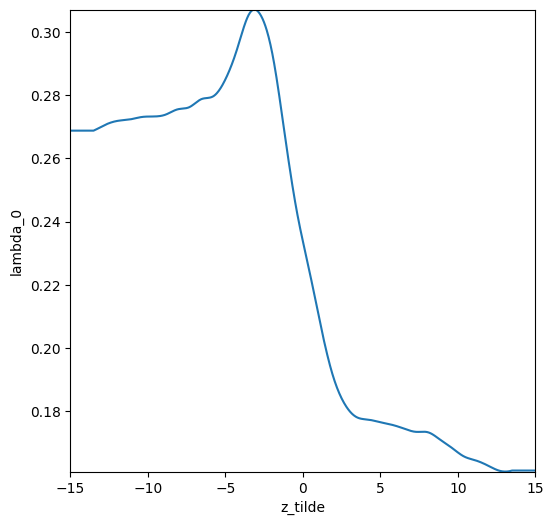

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


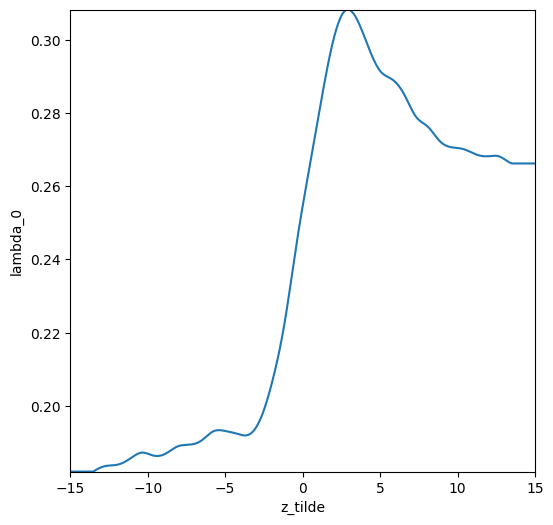

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


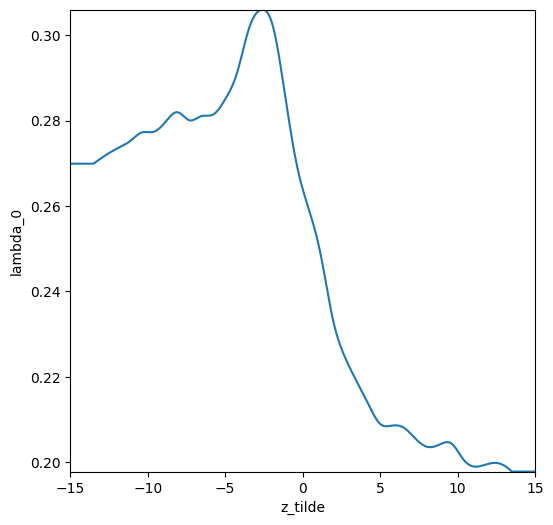

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)